In [1]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from skimage import io, img_as_float
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

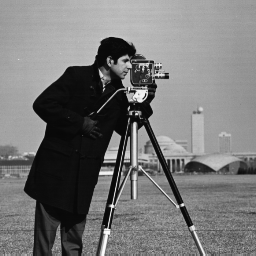

In [3]:
image = cv2.imread('/content/drive/MyDrive/AIP_A4/cameraman.tif', cv2.IMREAD_UNCHANGED)

# Display the image
cv2_imshow(image)

# Convert the image to a NumPy array
image_array = np.array(image,dtype=np.int16)

# Question 1

In [4]:
def calculate_T_matrix(N):
  T = np.zeros((N, N))
  for i in range(N):
    for j in range(N):
      if(i==0):
        T[i, j] = np.sqrt(1/N)
      else:
        T[i, j] = np.sqrt(2/N) * np.cos((np.pi/(2*N)) * (2*j + 1) * i)
  return T

In [5]:
def calculate_DCT(T,image_array):
  window_size = T.shape[0]
  DCT = np.zeros_like(image_array)
  for i in range(0,image_array.shape[0],window_size):
    for j in range(0,image_array.shape[1],window_size):
      block = image_array[i:i+window_size, j:j+window_size]
      DCT[i:i+window_size, j:j+window_size] = T @ block @ T.T

  return DCT

In [6]:
def calculate_inverse_DCT(T,image_array):
  window_size = T.shape[0]
  IDCT = np.zeros_like(image_array)
  for i in range(0,image_array.shape[0],window_size):
    for j in range(0,image_array.shape[1],window_size):
      block = image_array[i:i+window_size, j:j+window_size]
      IDCT[i:i+window_size, j:j+window_size] = T.T @ block @ T

  return IDCT

In [7]:
def calculate_quantized_matrix(quantization_matrix,DCT):
  window_size = quantization_matrix.shape[0]
  quantized_matrix = np.zeros_like(DCT)
  for i in range(0,DCT.shape[0],window_size):
    for j in range(0,DCT.shape[1],window_size):
      quantized_matrix[i:i+window_size, j:j+window_size]  = np.floor(DCT[i:i+window_size, j:j+window_size]/quantization_matrix + 0.5)
    
  return quantized_matrix

In [8]:
def get_index_code(coeff):
    # Check if coefficient is zero
    if coeff == 0:
        return '0'
    
    # Check if coefficient is -1 or 1
    temp1 = np.array([-1, 1])
    if coeff in temp1:
        binary_code = bin(np.where(temp1 == coeff)[0][0])[2:]
        padding = '0' * (1-len(binary_code))
        return '10' + padding + binary_code
    
    # Check if coefficient is -3, -2, 2, or 3
    temp2 = np.array([-3, -2, 2, 3])
    if coeff in temp2:
        binary_code = bin(np.where(temp2 == coeff)[0][0])[2:]
        padding = '0' * (2-len(binary_code))
        return '110' + padding + binary_code
    
    # Check if coefficient is -7, -6, -5, -4, 4, 5, 6, or 7
    temp3 = np.array([-7, -6, -5, -4, 4, 5, 6, 7])
    if coeff in temp3:
        binary_code = bin(np.where(temp3 == coeff)[0][0])[2:]
        padding = '0' * (3-len(binary_code))
        return '1110' + padding + binary_code
    
    # Check if coefficient is in the range -15 to -8 or 8 to 15
    temp4 = np.concatenate([np.arange(-15, -7), np.arange(8, 16)])
    if coeff in temp4:
        binary_code = bin(np.where(temp4 == coeff)[0][0])[2:]
        padding = '0' * (4-len(binary_code))
        return '11110' + padding + binary_code
    
    # Check if coefficient is in the range -31 to -16 or 16 to 31
    temp5 = np.concatenate([np.arange(-31, -15), np.arange(16, 32)])
    if coeff in temp5:
        binary_code = bin(np.where(temp5 == coeff)[0][0])[2:]
        padding = '0' * (5-len(binary_code))
        return '111110' + padding + binary_code
    
    # Check if coefficient is in the range -63 to -32 or 32 to 63
    temp6 = np.concatenate([np.arange(-63, -31), np.arange(32, 64)])
    if coeff in temp6:
        binary_code = bin(np.where(temp6 == coeff)[0][0])[2:]
        padding = '0' * (6-len(binary_code))
        return '1111110' + padding + binary_code
    
    # Check if coefficient is in the range -125 to -64 or 64 to 125
    temp7 = np.concatenate([np.arange(-127, -63), np.arange(64, 128)])
    if coeff in temp7:
        binary_code = bin(np.where(temp7 == coeff)[0][0])[2:]
        padding = '0' * (7-len(binary_code))
        return '11111110' + padding + binary_code
    
    # If coefficient doesn't match any of the above cases, return an empty string
    return ''

In [9]:
def get_decoded_vector(encoded_str):
  # Initialize an empty list to store decoded coefficients
  decoded_coeffs = []


  # Loop through the encoded string and decode each coefficient
  i = 0
  while i < len(encoded_str):
    # print(decoded_coeffs)
    # Check if current code is '0'
    if encoded_str[i] == '0':
      decoded_coeffs.append(0)
      # print(i,'0',0)
      i += 1
    # Check if current code is '10'
    elif encoded_str[i:i+2] == '10':
      # Get the binary code for the coefficient
      binary_code = encoded_str[i+2:i+3]
      # Convert binary code to decimal and get the corresponding coefficient
      coeff = np.array([-1, 1])[int(binary_code, 2)]
      decoded_coeffs.append(coeff)
      # print(i,'10',coeff)
      i += 3
    # Check if current code is '110'
    elif encoded_str[i:i+3] == '110':
      # Get the binary code for the coefficient
      binary_code = encoded_str[i+3:i+5]
      # Convert binary code to decimal and get the corresponding coefficient
      coeff = np.array([-3, -2, 2, 3])[int(binary_code, 2)]
      decoded_coeffs.append(coeff)
      # print(i,'110',coeff)
      i += 5
    # Check if current code is '1110'
    elif encoded_str[i:i+4] == '1110':
      # print("4")
      # Get the binary code for the coefficient
      binary_code = encoded_str[i+4:i+7]
      # Convert binary code to decimal and get the corresponding coefficient
      coeff = np.array([-7, -6, -5, -4, 4, 5, 6, 7])[int(binary_code, 2)]
      decoded_coeffs.append(coeff)
      # print(i,'1110',coeff)
      i += 7
    # Check if current code is '11110'
    elif encoded_str[i:i+5] == '11110':
      # Get the binary code for the coefficient
      binary_code = encoded_str[i+5:i+9]
      # Convert binary code to decimal and get the corresponding coefficient
      coeff = np.concatenate([np.arange(-15, -7), np.arange(8, 16)])[int(binary_code, 2)]
      decoded_coeffs.append(coeff)
      # print(i,'11110',coeff)
      i += 9
    # Check if current code is '111110'
    elif encoded_str[i:i+6] == '111110':
      # Get the binary code for the coefficient
      binary_code = encoded_str[i+6:i+11]
      # Convert binary code to decimal and get the corresponding coefficient
      coeff = np.concatenate([np.arange(-31, -15), np.arange(16, 32)])[int(binary_code, 2)]
      decoded_coeffs.append(coeff)
      # print(i,'111110',coeff)
      i += 11
    # Check if current code is '1111110'
    elif encoded_str[i:i+7] == '1111110':
      # Get the binary code for the coefficient
      binary_code = encoded_str[i+7:i+13]
      # Convert binary code to decimal and get the corresponding coefficient
      coeff = np.concatenate([np.arange(-63, -31), np.arange(32, 64)])[int(binary_code, 2)]
      decoded_coeffs.append(coeff)
      # print(i,'1111110',coeff)
      i += 13
    # Check if current code is '11111110'
    elif encoded_str[i:i+8] == '11111110':
      # Get the binary code for the coefficient
      binary_code = encoded_str[i+8:i+15]
      # Convert binary code to decimal and get the corresponding coefficient
      coeff = np.concatenate([np.arange(-127, -63), np.arange(64, 128)])[int(binary_code, 2)]
      decoded_coeffs.append(coeff)
      # print(i,'11111110',coeff)
      i += 15
    
    # If current code doesn't match any of the above cases, return an error message
    else:
      # print("hello2")
      decoded_coeffs.append(0)

  # Return the list of decoded coefficients
  return decoded_coeffs

In [10]:
def get_encoded_string(matrix):
  result = ''
  row, col = 0, 0
  going_up = True
  n_rows = matrix.shape[0]
  n_cols = matrix.shape[1]
  while row < n_rows and col < n_cols:
    result += get_index_code(matrix[row][col])
    if going_up:
      if col == n_cols - 1:
        row += 1
        going_up = False
      elif row == 0:
        col += 1
        going_up = False
      else:
        row -= 1
        col += 1
    else:
      if row == n_rows - 1:
        col += 1
        going_up = True
      elif col == 0:
        row += 1
        going_up = True
      else:
        row += 1
        col -= 1
  return result


In [11]:
def convert_zigzag_traversal_to_matrix(zigzag_list):
  n_rows = n_cols = int(np.sqrt(len(zigzag_list)))
  # Initialize the matrix with zeros
  matrix = [[0 for _ in range(n_cols)] for _ in range(n_rows)]
  
  # Set the initial row and column indices to zero
  row, col = 0, 0
  
  # Set the direction of traversal to up-right or down-left
  going_up = True
  
  # Traverse the zigzag_list and fill in the matrix
  for i, value in enumerate(zigzag_list):
    matrix[row][col] = value
    
    # Update the row and column indices based on the direction of traversal
    if going_up:
      if col == n_cols - 1:
        row += 1
        going_up = False
      elif row == 0:
        col += 1
        going_up = False
      else:
        row -= 1
        col += 1
    else:
      if row == n_rows - 1:
        col += 1
        going_up = True
      elif col == 0:
        row += 1
        going_up = True
      else:
        row += 1
        col -= 1
  matrix = np.array(matrix)
  return matrix


In [12]:
def recover_image(quantization_matrix,decoded_matrix):
  window_size = quantization_matrix.shape[0]
  reconstructed_image = np.zeros_like(decoded_matrix)
  for i in range(0,decoded_matrix.shape[0],window_size):
    for j in range(0,decoded_matrix.shape[1],window_size):
      reconstructed_image[i:i+window_size, j:j+window_size]  = decoded_matrix[i:i+window_size, j:j+window_size]*quantization_matrix
  
  return reconstructed_image


### Discrete cosine transform

In [58]:
window_size = 8
T = calculate_T_matrix(window_size)

# Centering around 0 
centered_array = image_array - 128

DCT = calculate_DCT(T,centered_array)

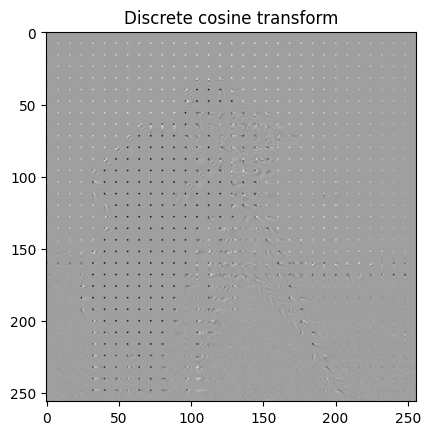

In [59]:
plt.imshow(DCT, cmap='gray')
plt.title("Discrete cosine transform")
# show the plot
plt.show()

### Quantized matrix

In [60]:
#Quantization matrix
quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])




quantized_matrix = calculate_quantized_matrix(quantization_matrix,DCT)

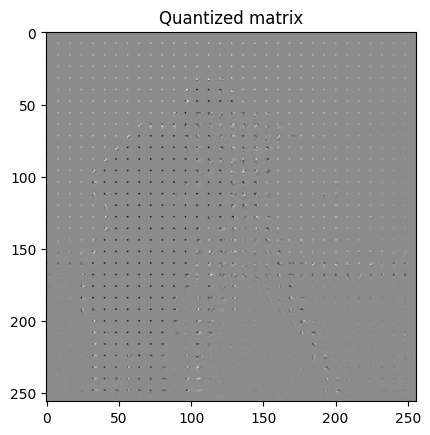

In [61]:
plt.imshow(quantized_matrix, cmap='gray')
plt.title("Quantized matrix")
# show the plot
plt.show()

### Compression ratio

In [62]:
compressed_image = get_encoded_string(quantized_matrix)

input_image_size = image_array.size*image_array.itemsize*8

output_image_size = len(compressed_image)

compression_ratio = input_image_size/output_image_size

print("Compression ration is: ",compression_ratio)

Compression ration is:  10.077422827048014


In [63]:
print("Size of original image in KB:",image_array.size*image_array.itemsize*8 / 8 / 1024)

Size of original image in KB: 128.0


In [64]:
print("Size of compressed image in KB:",len(compressed_image)/ 8 / 1024)

Size of compressed image in KB: 12.70166015625


### Reconstructed image

In [65]:
decoded_vector = get_decoded_vector(compressed_image)

decoded_matrix = convert_zigzag_traversal_to_matrix(decoded_vector)

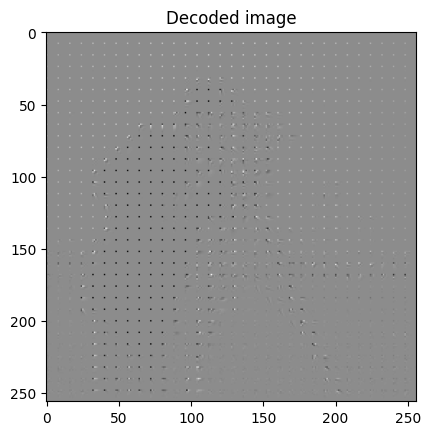

In [66]:
plt.imshow(decoded_matrix, cmap='gray')
plt.title("Decoded image")
# show the plot
plt.show()

In [67]:
reconstructed_image1 = recover_image(quantization_matrix,decoded_matrix)

reconstructed_image2 = calculate_inverse_DCT(T,reconstructed_image1)

final_reconstructed_image = reconstructed_image2 + 128

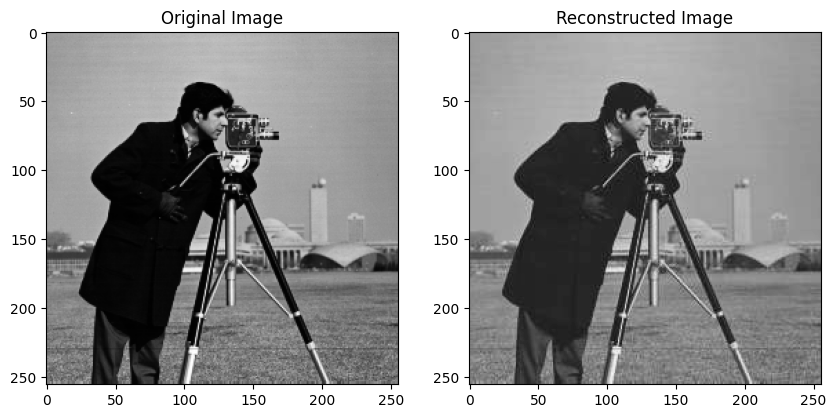

In [69]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image in the left subplot
axs[0].imshow(image_array, cmap='gray')
axs[0].set_title('Original Image')

# Display the second image in the right subplot
axs[1].imshow(final_reconstructed_image, cmap='gray')
axs[1].set_title('Reconstructed Image')

# Display the plot
plt.show()

In [22]:
MSE = mean_squared_error(image_array, final_reconstructed_image)
print("Mean squared error between original and compressed image is:",MSE)

Mean squared error between original and compressed image is: 44.713623046875


### Compression with different qualities

In [41]:
# scale_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
scale_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
scale_values = list(range(1, 101))

# scale_values= [0.4]
Compression_ratio = np.zeros(len(scale_values))
MSE_values = np.zeros(len(scale_values))
compressed_file_size = np.zeros(len(scale_values))

T = calculate_T_matrix(window_size)

# Centering around 0 
centered_array = image_array - 128
# print(centered_array)
DCT = calculate_DCT(T,centered_array)
# print(DCT)
for i,scale_factor in enumerate(scale_values):
  new_quantization_matrix = quantization_matrix*scale_factor
  quantized_matrix = calculate_quantized_matrix(new_quantization_matrix,DCT)
  compressed_image = get_encoded_string(quantized_matrix)
  decoded_vector = get_decoded_vector(compressed_image)
  # print(len(decoded_vector))
  decoded_matrix = convert_zigzag_traversal_to_matrix(decoded_vector)
  reconstructed_image1 = recover_image(quantization_matrix,decoded_matrix)
  reconstructed_image2 = calculate_inverse_DCT(T,reconstructed_image1)
  final_reconstructed_image = reconstructed_image2 + 128
  
  compressed_file_size[i] = (len(compressed_image)/8/1024)
  Compression_ratio[i] = len(compressed_image)/image_array.size*image_array.itemsize*8
  MSE_values[i] = mean_squared_error(image_array, final_reconstructed_image)

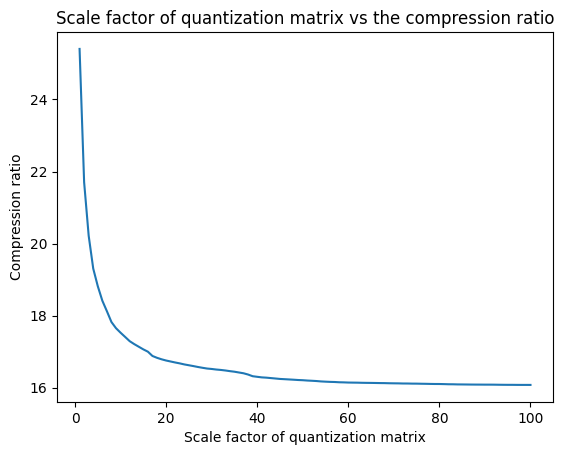

In [50]:
plt.plot(scale_values,Compression_ratio)
plt.xlabel("Scale factor of quantization matrix")
plt.ylabel("Compression ratio")
plt.title("Scale factor of quantization matrix vs the compression ratio")
plt.show()

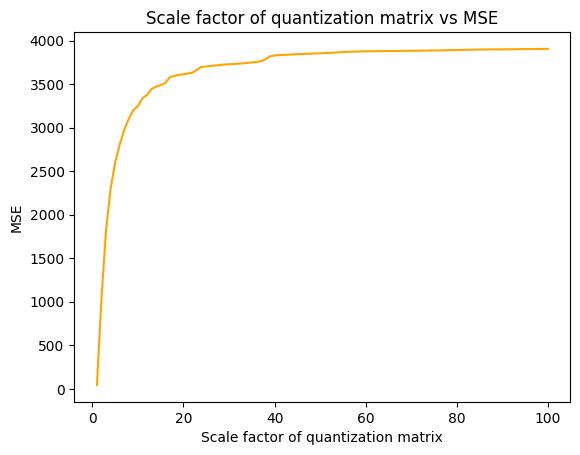

In [51]:
plt.plot(scale_values,MSE_values,color="orange")
plt.xlabel("Scale factor of quantization matrix")
plt.ylabel("MSE")
plt.title("Scale factor of quantization matrix vs MSE")
plt.show()

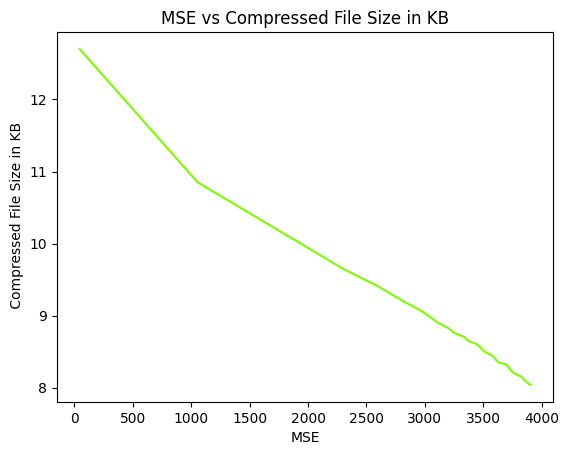

In [52]:
plt.plot(MSE_values,compressed_file_size,color = "lawngreen")
plt.xlabel("MSE")
plt.ylabel(" Compressed File Size in KB")
plt.title("MSE vs Compressed File Size in KB")
plt.show()

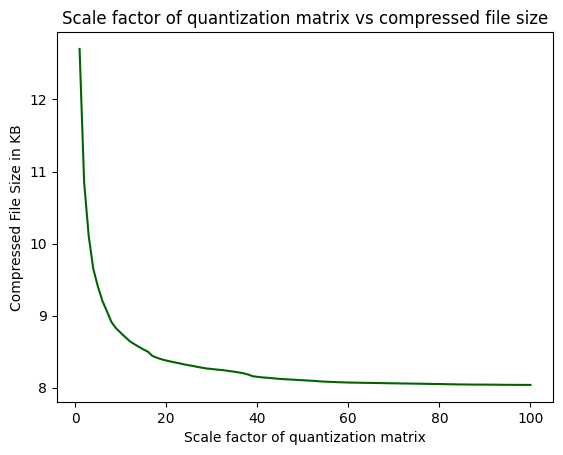

In [53]:
plt.plot(scale_values,compressed_file_size,color = "darkgreen")
plt.xlabel("Scale factor of quantization matrix")
plt.ylabel("Compressed File Size in KB")
plt.title("Scale factor of quantization matrix vs compressed file size")
plt.show()